# CLIPPO colab

Paper: [Image-and-Language Understanding from Pixels Only](https://arxiv.org/abs/2212.08045)

This colab shows how to
- load pretrained CLIP with Pixels Only (CLIPPO) models,
- use them to compute image and text embeddings,
- perform zero-shot image and text classification.

Six ViT-B/16 models trained on a mix of [YFCC-100M](https://arxiv.org/abs/1503.01817) and [C4](https://arxiv.org/abs/1910.10683) (some initialized with an [ImageNet21k-pretrained checkpoint](https://github.com/google-research/vision_transformer#vision-transformer)\) are available. Please refer to the [GitHub readme](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/clippo/README.md) for training code and details on the checkpoints.

This colab is derived from the [colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/lit.ipynb) accompanying the paper [LiT: Zero-Shot Transfer with Locked-Image Text Tuning](https://arxiv.org/abs/2111.07991).

## Set up the environment

In [1]:
# Clone the big_vision repository
!git clone --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull

Cloning into 'big_vision'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 210 (delta 40), reused 102 (delta 18), pack-reused 0
Receiving objects: 100% (210/210), 470.30 KiB | 10.94 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Already up to date.


In [2]:
# Install the python dependencies
!pip install -qr big_vision/big_vision/requirements.txt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Download Unifont for text rendering
!wget https://unifoundry.com/pub/unifont/unifont-9.0.06/font-builds/unifont-9.0.06.hex.gz https://unifoundry.com/pub/unifont/unifont-9.0.06/font-builds/unifont_upper-9.0.06.hex.gz
!gunzip unifont-9.0.06.hex.gz unifont_upper-9.0.06.hex.gz
!mv unifont-9.0.06.hex unifont_upper-9.0.06.hex big_vision/big_vision/pp/proj/clippo/

--2023-03-15 14:24:14--  https://unifoundry.com/pub/unifont/unifont-9.0.06/font-builds/unifont-9.0.06.hex.gz
Resolving unifoundry.com (unifoundry.com)... 107.180.4.157
Connecting to unifoundry.com (unifoundry.com)|107.180.4.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939547 (918K) [application/x-gzip]
Saving to: ‘unifont-9.0.06.hex.gz’

unifont-9.0.06.hex. 100%[===================>] 917.53K  1.14MB/s    in 0.8s    

2023-03-15 14:24:15 (1.14 MB/s) - ‘unifont-9.0.06.hex.gz’ saved [939547/939547]

--2023-03-15 14:24:15--  https://unifoundry.com/pub/unifont/unifont-9.0.06/font-builds/unifont_upper-9.0.06.hex.gz
Reusing existing connection to unifoundry.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 112342 (110K) [application/x-gzip]
Saving to: ‘unifont_upper-9.0.06.hex.gz’

unifont_upper-9.0.0 100%[===================>] 109.71K  --.-KB/s    in 0.001s  

2023-03-15 14:24:15 (165 MB/s) - ‘unifont_upper-9.0.06.hex.gz’ saved [112342/112342]



In [4]:
%cd big_vision

/content/big_vision


## Load a checkpoint and initialize the model

In [5]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import importlib

In [6]:
# Select the checkpoint and download it
checkpoint_paths = {
    'clippo_b16_yfcc100m': 'gs://big_vision/clippo/clippo_b16_yfcc100m.npz',
    'clippo_b16_yfcc100m_i21k_init': 'gs://big_vision/clippo/clippo_b16_yfcc100m_i21k_init.npz',
    'clippo_b16_yfcc100m_i21k_init_25c4': 'gs://big_vision/clippo/clippo_b16_yfcc100m_i21k_init_25c4.npz',
    'clippo_b16_yfcc100m_i21k_init_50c4': 'gs://big_vision/clippo/clippo_b16_yfcc100m_i21k_init_50c4.npz',
    'clippo_b16_yfcc100m_i21k_init_75c4': 'gs://big_vision/clippo/clippo_b16_yfcc100m_i21k_init_75c4.npz',
    'clippo_b16_100c4': 'gs://big_vision/clippo/clippo_b16_100c4.npz'
}

checkpoint = 'clippo_b16_yfcc100m_i21k_init_25c4'
checkpoint_path = checkpoint_paths[checkpoint]
!gsutil cp $checkpoint_path .

Copying gs://big_vision/clippo/clippo_b16_yfcc100m_i21k_init_25c4.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][540.4 MiB/540.4 MiB]                                                
Operation completed over 1 objects/540.4 MiB.                                    


In [7]:
from big_vision.configs.proj.clippo import train_clippo
from big_vision import utils

# The models are trained for resolution 224
RES = 224

# Load model module
config = train_clippo.get_config()
model_module = importlib.import_module(f'big_vision.models.{config.model_name}')
model = model_module.Model(**config.model)

# Load model parameters
params = utils.load_checkpoint(None, checkpoint_path)['params']

In [8]:
# Define and load preprocessing functions
from big_vision.pp import builder as pp_builder
for pp_modules in config.pp_modules:
  importlib.import_module(f'big_vision.pp.{pp_modules}')

# Unifont renderer
def tokenizer(inkey='text', outkey='text'):
  return (f'render_unifont('
          f'inkey="{inkey}", '
          f'outkey="{outkey}", '
          f'image_size={RES}, '
          f'lower=True, '
          f'font_size=16, '
          f'text_brightness=0, '
          f'background_brightness=127)|'
          f'value_range(-1, 1, inkey="{outkey}", outkey="{outkey}")')

pp_image_str = f'resize({RES})|value_range(-1,1)'
pp_text_str = tokenizer()

pp_image_fn = pp_builder.get_preprocess_fn(pp_image_str)
pp_text_fn = pp_builder.get_preprocess_fn(pp_text_str)

def preprocess_images(images):
  return [np.array(pp_image_fn({'image': img})['image']) for img in images]

def preprocess_texts(texts):
  return [np.array(pp_text_fn({'text': text})['text']) for text in texts]

## Use the model

### Compute and compare image/text embeddings

In [9]:
# Load some sample images from tfds
# Alternatively you can also load these images from the internet / your Drive
ds = tfds.load('imagenette', split='train')
image_list = [
    example['image'].numpy()
    for _, example in zip(range(5), ds)
]
# Note that this is a list of images with different shapes, not a four
# dimensional tensor.
[image.shape for image in image_list]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteZXF06J/imagenette-train.tfrecord*.…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteZXF06J/imagenette-validation.tfrec…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


[(101, 125, 3), (375, 500, 3), (335, 500, 3), (429, 500, 3), (359, 500, 3)]

In [10]:
text_list = [
    'itap of a cd player',
    'a photo of a truck',
    'gas station',
    'chainsaw',
    'a bad photo of colorful houses',
]

In [11]:
images = preprocess_images(image_list)
texts = preprocess_texts(text_list)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
plt.figure(figsize=(30, 12))
plt.subplot(211)
plt.imshow(np.hstack(images) * .5 + .5)
plt.axis('off');
plt.subplot(212)
plt.imshow(np.hstack(texts) * .5 + .5)
plt.axis('off')

(-0.5, 1119.5, 223.5, -0.5)

In [13]:
# Embed both texts and images with a single model call
# See "zero-shot evaluation" below for how to do this separately
zimg, ztxt, out = model.apply({"params": params}, jnp.stack(images), jnp.stack(texts))

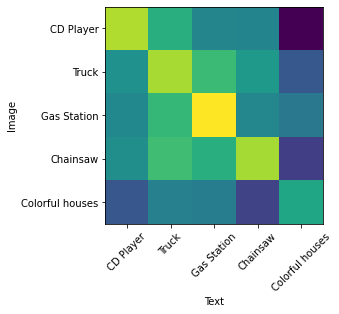

In [14]:
# Visualize embedding similarities
plt.imshow(ztxt @ zimg.T)
plt.xlabel("Text")
plt.ylabel("Image")
tick_labels = ["CD Player", "Truck", "Gas Station", "Chainsaw", "Colorful houses"]
plt.xticks(ticks=range(5),labels=tick_labels, rotation=45)
plt.yticks(ticks=range(5),labels=tick_labels, rotation=0)
plt.show()

In [15]:
probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
pd.DataFrame(probs, index=text_list).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}')

,0,1,2,3,4
itap of a cd player,98.83%,1.07%,0.05%,0.05%,0.00%
a photo of a truck,0.15%,96.14%,3.46%,0.25%,0.00%
gas station,0.01%,0.25%,99.73%,0.01%,0.00%
chainsaw,0.12%,4.22%,1.34%,94.32%,0.00%
a bad photo of colorful houses,0.30%,5.81%,4.67%,0.09%,89.12%


### Compute and compare sentence embeddings

Since we co-train some of our models on pairs of neighboring sentences from C4
with the same contrastive loss as used for image/alt-text pairs, we expect the
embeddings to capture sentence similarities well. Indeed, our GLUE evaluations
show that CLIPPO learns good sentenence embeddings.

Below we visualize the similarities between pairs of neigboring sentences form
different Wikipedia articles. CLIPPO models with C4 in the training mix assign
higher similarties to sentences from the same article than from different
article.

In [16]:
# Selection of sentence pairs from Wikipedia (collected on 3/7/2023)
sentence_pairs = [
    # https://en.wikipedia.org/wiki/Google_JAX
    ['Google JAX is a machine learning framework for transforming numerical functions.',
     'It is described as bringing together a modified version of autograd (automatic obtaining of the gradient function through differentiation of a function) and TensorFlow\'s XLA (Accelerated Linear Algebra).'],
    # https://en.wikipedia.org/wiki/Matterhorn
    ['The Matterhorn (/ˈmætərhɔːrn/, German: [ˈmatɐˌhɔʁn]; Italian: Cervino, [tʃerˈviːno]; French: Cervin, [sɛʁvɛ̃]; Romansh: Mont(e) Cervin(u)) is a mountain of the Alps, straddling the main watershed and border between Switzerland and Italy.',
     'It is a large, near-symmetric pyramidal peak in the extended Monte Rosa area of the Pennine Alps, whose summit is 4,478 metres (14,692 ft) high, making it one of the highest summits in the Alps and Europe.'],
    # https://en.wikipedia.org/wiki/Claude_Shannon
    ['Claude Elwood Shannon (April 30, 1916 – February 24, 2001) was an American mathematician, electrical engineer, and cryptographer known as a "father of information theory".',
     'As a 21-year-old master\'s degree student at the Massachusetts Institute of Technology (MIT), he wrote his thesis demonstrating that electrical applications of Boolean algebra could construct any logical numerical relationship.'],
    # https://en.wikipedia.org/wiki/Z%C3%BCrich
    ['Zürich (/ˈzjʊərɪk, ˈzʊərɪk/ ZURE-ik, ZOOR-ik, German: [ˈtsyːrɪç] (listen); see below) is the largest city in Switzerland and the capital of the canton of Zürich.',
     'It is located in north-central Switzerland, at the northwestern tip of Lake Zürich.'],
]

# Preprocess sentences
sentence_lists = list(zip(*sentence_pairs))
first_sentences = preprocess_texts(sentence_lists[0])
second_sentences = preprocess_texts(sentence_lists[1])

In [17]:
plt.figure(figsize=(30, 12))
plt.subplot(211)
plt.imshow(np.hstack(first_sentences) * .5 + .5)
plt.axis('off');
plt.subplot(212)
plt.imshow(np.hstack(second_sentences) * .5 + .5)
plt.axis('off')

(-0.5, 895.5, 223.5, -0.5)

In [18]:
# Compute and compare embeddings
ztxt1, ztxt2, out = model.apply({"params": params}, jnp.stack(first_sentences), jnp.stack(second_sentences))

In [19]:
probs_txt = np.array(jax.nn.softmax(out['t'] * ztxt1 @ ztxt2.T, axis=1))
pd.DataFrame(probs_txt).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}')

,0,1,2,3
0,98.74%,0.00%,1.26%,0.00%
1,0.00%,98.67%,0.00%,1.33%
2,2.96%,0.01%,96.99%,0.05%
3,0.00%,0.00%,0.00%,100.00%


## `tfds` zero-shot evaluation

We provide two zero-shot clasification examples
- Image classification on CIFAR-100 (run cells after "Dataset and preprocessing preparation CIFAR-100")
- Text classification on SST-2 (run cells after "Dataset and preprocessing preparation SST-2")

After that, run the cells after "Zero-shot classification" cells to perform the classification.

#### Dataset and preprocessing preparation CIFAR-100

In [20]:
# Load dataset
builder = tfds.builder('cifar100')
builder.download_and_prepare()
ds_test = builder.as_dataset('test')

# Use image preprocessing function defined earlier
ds_test = ds_test.map(pp_image_fn)

# Create array of class names
info = builder.info
classnames = [
    info.features['label'].int2str(id_)
    for id_ in range(info.features['label'].num_classes)
]
classnames[:10]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteW3MSAW/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteW3MSAW/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

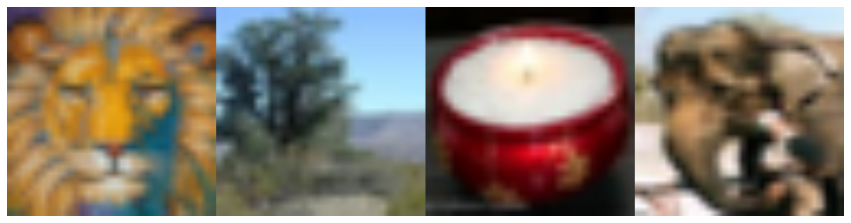

In [21]:
imgs = next(iter(ds_test.batch(4)))['image']

plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(imgs) * .5 + .5)
plt.axis('off');

In [22]:
#@markdown *Prompt engineering*\
#@markdown The [official CLIP Colab](https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb)
#@markdown lists two sets of prompts: the 80 prompts mentioned in the [CLIP paper](https://arxiv.org/abs/2103.00020)
#@markdown as well as a shortlist of 7 prompts. That will be used by default for speed,
#@markdown but using 80 prompts boosts performance a bit.
use_80_prompts = False #@param {"type": "boolean"}
if use_80_prompts:
  PROMPTS = [
      'a bad photo of a {}.',
      'a photo of many {}.',
      'a sculpture of a {}.',
      'a photo of the hard to see {}.',
      'a low resolution photo of the {}.',
      'a rendering of a {}.',
      'graffiti of a {}.',
      'a bad photo of the {}.',
      'a cropped photo of the {}.',
      'a tattoo of a {}.',
      'the embroidered {}.',
      'a photo of a hard to see {}.',
      'a bright photo of a {}.',
      'a photo of a clean {}.',
      'a photo of a dirty {}.',
      'a dark photo of the {}.',
      'a drawing of a {}.',
      'a photo of my {}.',
      'the plastic {}.',
      'a photo of the cool {}.',
      'a close-up photo of a {}.',
      'a black and white photo of the {}.',
      'a painting of the {}.',
      'a painting of a {}.',
      'a pixelated photo of the {}.',
      'a sculpture of the {}.',
      'a bright photo of the {}.',
      'a cropped photo of a {}.',
      'a plastic {}.',
      'a photo of the dirty {}.',
      'a jpeg corrupted photo of a {}.',
      'a blurry photo of the {}.',
      'a photo of the {}.',
      'a good photo of the {}.',
      'a rendering of the {}.',
      'a {} in a video game.',
      'a photo of one {}.',
      'a doodle of a {}.',
      'a close-up photo of the {}.',
      'a photo of a {}.',
      'the origami {}.',
      'the {} in a video game.',
      'a sketch of a {}.',
      'a doodle of the {}.',
      'a origami {}.',
      'a low resolution photo of a {}.',
      'the toy {}.',
      'a rendition of the {}.',
      'a photo of the clean {}.',
      'a photo of a large {}.',
      'a rendition of a {}.',
      'a photo of a nice {}.',
      'a photo of a weird {}.',
      'a blurry photo of a {}.',
      'a cartoon {}.',
      'art of a {}.',
      'a sketch of the {}.',
      'a embroidered {}.',
      'a pixelated photo of a {}.',
      'itap of the {}.',
      'a jpeg corrupted photo of the {}.',
      'a good photo of a {}.',
      'a plushie {}.',
      'a photo of the nice {}.',
      'a photo of the small {}.',
      'a photo of the weird {}.',
      'the cartoon {}.',
      'art of the {}.',
      'a drawing of the {}.',
      'a photo of the large {}.',
      'a black and white photo of a {}.',
      'the plushie {}.',
      'a dark photo of a {}.',
      'itap of a {}.',
      'graffiti of the {}.',
      'a toy {}.',
      'itap of my {}.',
      'a photo of a cool {}.',
      'a photo of a small {}.',
      'a tattoo of the {}.',
  ]
else:
  PROMPTS = [
      'itap of a {}.',
      'a bad photo of the {}.',
      'a origami {}.',
      'a photo of the large {}.',
      'a {} in a video game.',
      'art of the {}.',
      'a photo of the small {}.',
      '{}',
  ]

In [23]:
# Construct prompts for all templates
class_prompts = [
    prompt.format(classname)
    for classname in classnames
    for prompt in PROMPTS
]
len(class_prompts)

800

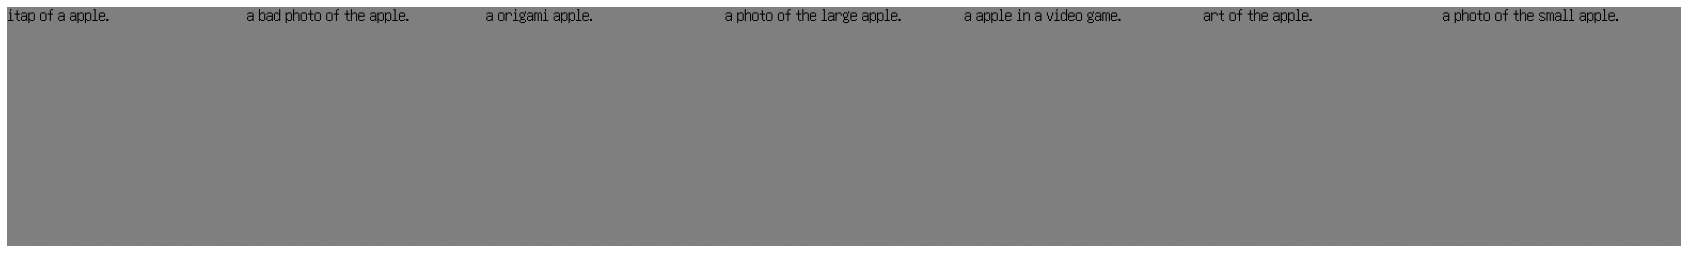

In [24]:
# Render prompt images for all classes and visualize them
text_images = preprocess_texts(class_prompts [:7])

plt.figure(figsize=(30, 6))
plt.imshow(np.hstack(text_images) * .5 + .5)
plt.axis('off');

#### Dataset and preprocessing preparation SST-2

The goal of SST-2 is sentiment classification (`positive`, `negative`) of movie
reviews. To this end we embed the reviews and a few prompts for positive/negative sentiment using CLIPPO and compare the embeddings to perform zero-shot
classification.

In [30]:
# Load dataset and create array of class names.
builder = tfds.builder('glue/sst2')
builder.download_and_prepare()
# The validation set has 428 negative vs. 444 positive examples,
# so a naive classifier would obtain an accuracy of 50.9 %
ds_test = builder.as_dataset('validation')

# Create pp rendering function for SST-2 and map the data set
pp_fn_sst2 = pp_builder.get_preprocess_fn(tokenizer('sentence', 'image'))
ds_test = ds_test.map(pp_fn_sst2)

info = builder.info
classnames = [
    info.features['label'].int2str(id_)
    for id_ in range(info.features['label'].num_classes)
]
classnames

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteEYA068/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteEYA068/glue-validation.tfrecord*...:   0%|      …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteEYA068/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.


['negative', 'positive']

In [31]:
sentences = next(iter(ds_test.batch(4)))['sentence']
sentences

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'a valueless kiddie paean to pro basketball underwritten by the nba . ',
       b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . ",
       b'i am sorry that i was unable to get the full brunt of the comedy . ',
       b'the inspirational screenplay by mike rich covers a lot of ground , perhaps too much , but ties things together , neatly , by the end . '],
      dtype=object)>

In [32]:
PROMPTS = (
    'a {} review',
    'a {} movie review',
    'a {} sentiment',
    'the movie was received {}',
    'the reception was {}',
    )
class_prompts = [p.format(c) for c in classnames for p in PROMPTS]
len(class_prompts)

10

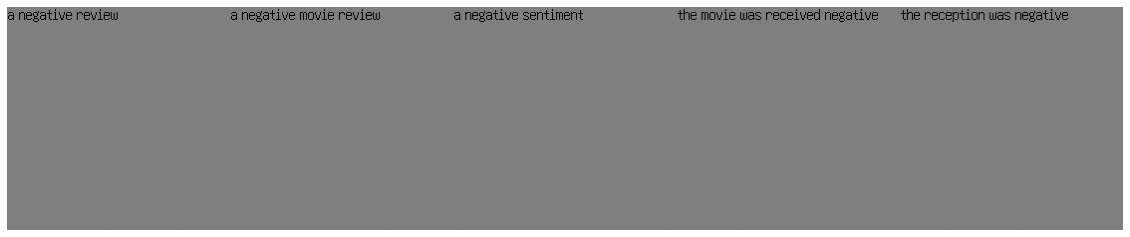

In [33]:
# Render prompt images for all classes and visualize them
text_images = preprocess_texts(class_prompts [:5])

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(text_images) * .5 + .5)
plt.axis('off');

### Zero-shot classification

In [25]:
# JIT-compile image embedding function to speed up the processing
@jax.jit
def embed_images(params, images):
  zimg, _, _ = model.apply({"params": params}, image=images)
  return zimg

In [26]:
# Compute class embeddings
zclass = []
for i in range(0, len(class_prompts), 100):
  batch = class_prompts[i : i + 100]
  batch = np.stack(preprocess_texts(batch))
  zbatch = embed_images(params, batch)
  zclass.append(zbatch)

zclass = np.concatenate(zclass)
zclass.shape


(800, 768)

In [27]:
# Compute all image/sentence embeddings and collect the correct labels
zimgs = []
labels = []

for batch in tqdm.tqdm(ds_test.batch(500)):
  labels += list(batch['label'].numpy())
  zimg = embed_images(params, batch['image'].numpy())
  zimgs.append(np.array(zimg))
zimgs = np.concatenate(zimgs)
zimgs.shape

100%|██████████| 20/20 [03:17<00:00,  9.87s/it]


(10000, 768)

In [28]:
# Compute similarities ...
sims = zimgs @ zclass.reshape([len(classnames), len(PROMPTS), -1]).mean(axis=1).T
sims.shape

(10000, 100)

In [29]:
# ... and use most similar embedding to predict label.
(sims.argmax(axis=1) == np.array(labels)).mean()

0.5092

In [30]:
# CIFAR-100 expected results (7 prompts)
#
# clippo_b16_yfcc100m: 0.4535
# clippo_b16_yfcc100m_i21k_init: 0.5183
# clippo_b16_yfcc100m_i21k_init_25c4: 0.5092
# clippo_b16_yfcc100m_i21k_init_50c4: 0.4862
# clippo_b16_yfcc100m_i21k_init_50c4: 0.4204
#
# SST-2 expected results
#
# clippo_b16_yfcc100m_i21k_init_25c4: 0.6754
# clippo_b16_yfcc100m_i21k_init_75c4: 0.7006